# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

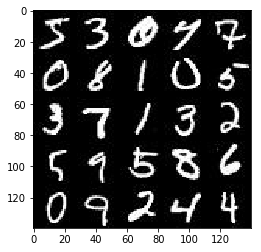

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

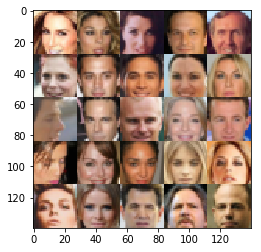

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse = reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64    

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [27]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    stddev = 0.01
    with tf.variable_scope('generator', reuse = not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x5 now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [28]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [29]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [30]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [31]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    alpha = 0.2
    
    input_real, input_z, l_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=alpha)
    d_opt, g_opt = model_opt(d_loss, g_loss, l_rate, beta1)

    steps = 0
    print_every=10
    show_every=100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2 #scale in the range of -1 and 1
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, l_rate : learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, l_rate : learning_rate}) 
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6343... Generator Loss: 4.2124
Epoch 1/2... Discriminator Loss: 0.4537... Generator Loss: 8.5052
Epoch 1/2... Discriminator Loss: 0.4433... Generator Loss: 4.3462
Epoch 1/2... Discriminator Loss: 2.1017... Generator Loss: 14.3659
Epoch 1/2... Discriminator Loss: 0.7495... Generator Loss: 2.2104
Epoch 1/2... Discriminator Loss: 0.7567... Generator Loss: 1.8318
Epoch 1/2... Discriminator Loss: 0.6923... Generator Loss: 1.9282
Epoch 1/2... Discriminator Loss: 1.8198... Generator Loss: 0.4541
Epoch 1/2... Discriminator Loss: 1.1033... Generator Loss: 1.4214
Epoch 1/2... Discriminator Loss: 1.0048... Generator Loss: 1.6509


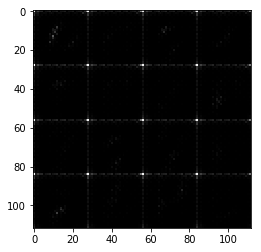

Epoch 1/2... Discriminator Loss: 0.9362... Generator Loss: 1.2475
Epoch 1/2... Discriminator Loss: 0.8743... Generator Loss: 2.2440
Epoch 1/2... Discriminator Loss: 1.0450... Generator Loss: 1.7141
Epoch 1/2... Discriminator Loss: 1.4585... Generator Loss: 0.6026
Epoch 1/2... Discriminator Loss: 1.1237... Generator Loss: 1.4187
Epoch 1/2... Discriminator Loss: 1.7815... Generator Loss: 0.3648
Epoch 1/2... Discriminator Loss: 1.5770... Generator Loss: 0.5242
Epoch 1/2... Discriminator Loss: 1.0513... Generator Loss: 1.4518
Epoch 1/2... Discriminator Loss: 1.2922... Generator Loss: 0.7348
Epoch 1/2... Discriminator Loss: 1.0865... Generator Loss: 0.9321


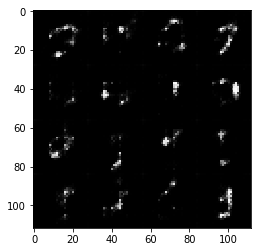

Epoch 1/2... Discriminator Loss: 1.1277... Generator Loss: 1.3294
Epoch 1/2... Discriminator Loss: 1.2446... Generator Loss: 1.0087
Epoch 1/2... Discriminator Loss: 1.1587... Generator Loss: 0.9985
Epoch 1/2... Discriminator Loss: 1.1746... Generator Loss: 0.8859
Epoch 1/2... Discriminator Loss: 1.1264... Generator Loss: 1.1043
Epoch 1/2... Discriminator Loss: 1.1045... Generator Loss: 1.0881
Epoch 1/2... Discriminator Loss: 0.9642... Generator Loss: 1.7164
Epoch 1/2... Discriminator Loss: 1.3599... Generator Loss: 0.6120
Epoch 1/2... Discriminator Loss: 1.4111... Generator Loss: 0.4899
Epoch 1/2... Discriminator Loss: 0.9950... Generator Loss: 1.2093


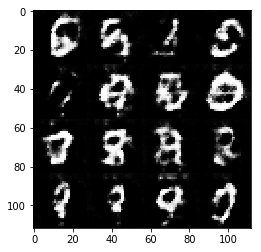

Epoch 1/2... Discriminator Loss: 1.1270... Generator Loss: 1.0709
Epoch 1/2... Discriminator Loss: 1.4835... Generator Loss: 0.5173
Epoch 1/2... Discriminator Loss: 0.9602... Generator Loss: 1.5536
Epoch 1/2... Discriminator Loss: 1.1119... Generator Loss: 1.1760
Epoch 1/2... Discriminator Loss: 0.9138... Generator Loss: 1.2650
Epoch 1/2... Discriminator Loss: 1.1453... Generator Loss: 0.8415
Epoch 1/2... Discriminator Loss: 1.3294... Generator Loss: 0.6296
Epoch 1/2... Discriminator Loss: 1.1374... Generator Loss: 0.8760
Epoch 1/2... Discriminator Loss: 1.1834... Generator Loss: 1.2729
Epoch 1/2... Discriminator Loss: 1.2815... Generator Loss: 0.6391


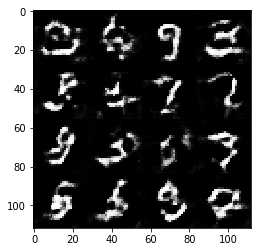

Epoch 1/2... Discriminator Loss: 1.0231... Generator Loss: 1.0821
Epoch 1/2... Discriminator Loss: 1.1898... Generator Loss: 1.9174
Epoch 1/2... Discriminator Loss: 1.1759... Generator Loss: 1.0828
Epoch 1/2... Discriminator Loss: 1.1452... Generator Loss: 0.7844
Epoch 1/2... Discriminator Loss: 1.0727... Generator Loss: 0.9762
Epoch 1/2... Discriminator Loss: 1.3196... Generator Loss: 0.6747
Epoch 1/2... Discriminator Loss: 1.8067... Generator Loss: 0.3161
Epoch 1/2... Discriminator Loss: 1.0115... Generator Loss: 1.0610
Epoch 1/2... Discriminator Loss: 1.1553... Generator Loss: 1.4907
Epoch 1/2... Discriminator Loss: 1.0175... Generator Loss: 1.2278


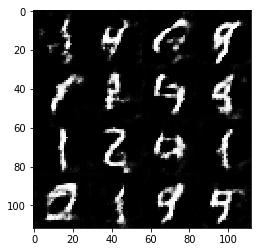

Epoch 1/2... Discriminator Loss: 1.1965... Generator Loss: 1.1281
Epoch 1/2... Discriminator Loss: 1.2579... Generator Loss: 0.6795
Epoch 1/2... Discriminator Loss: 1.1648... Generator Loss: 1.0426
Epoch 1/2... Discriminator Loss: 1.1845... Generator Loss: 0.9194
Epoch 1/2... Discriminator Loss: 1.1457... Generator Loss: 1.3427
Epoch 1/2... Discriminator Loss: 1.2327... Generator Loss: 0.7776
Epoch 1/2... Discriminator Loss: 1.3751... Generator Loss: 0.5774
Epoch 1/2... Discriminator Loss: 1.0681... Generator Loss: 0.8908
Epoch 1/2... Discriminator Loss: 1.0553... Generator Loss: 0.9778
Epoch 1/2... Discriminator Loss: 1.1236... Generator Loss: 0.9042


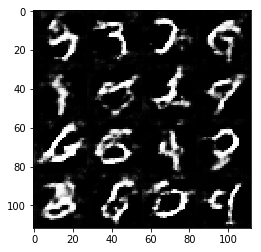

Epoch 1/2... Discriminator Loss: 1.1175... Generator Loss: 1.5633
Epoch 1/2... Discriminator Loss: 1.0652... Generator Loss: 1.3097
Epoch 1/2... Discriminator Loss: 1.1211... Generator Loss: 0.7502
Epoch 1/2... Discriminator Loss: 1.0508... Generator Loss: 0.9827
Epoch 1/2... Discriminator Loss: 1.3819... Generator Loss: 0.5559
Epoch 1/2... Discriminator Loss: 1.0469... Generator Loss: 1.1265
Epoch 1/2... Discriminator Loss: 1.1282... Generator Loss: 0.8065
Epoch 1/2... Discriminator Loss: 1.2364... Generator Loss: 0.7065
Epoch 1/2... Discriminator Loss: 1.1047... Generator Loss: 0.7718
Epoch 1/2... Discriminator Loss: 1.1048... Generator Loss: 1.0636


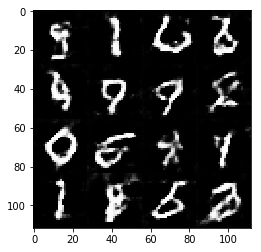

Epoch 1/2... Discriminator Loss: 1.3680... Generator Loss: 0.6385
Epoch 1/2... Discriminator Loss: 1.1763... Generator Loss: 0.8078
Epoch 1/2... Discriminator Loss: 1.0958... Generator Loss: 1.0211
Epoch 1/2... Discriminator Loss: 1.0880... Generator Loss: 1.6537
Epoch 1/2... Discriminator Loss: 1.1377... Generator Loss: 1.2387
Epoch 1/2... Discriminator Loss: 1.0478... Generator Loss: 0.9044
Epoch 1/2... Discriminator Loss: 1.1883... Generator Loss: 0.7491
Epoch 1/2... Discriminator Loss: 1.0198... Generator Loss: 1.3115
Epoch 1/2... Discriminator Loss: 1.0474... Generator Loss: 1.1201
Epoch 1/2... Discriminator Loss: 1.2197... Generator Loss: 0.6754


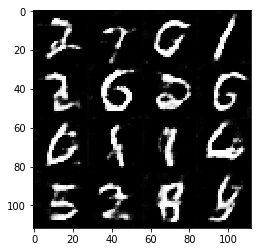

Epoch 1/2... Discriminator Loss: 1.0266... Generator Loss: 1.0871
Epoch 1/2... Discriminator Loss: 1.0729... Generator Loss: 1.6450
Epoch 1/2... Discriminator Loss: 1.0627... Generator Loss: 1.6488
Epoch 1/2... Discriminator Loss: 0.8670... Generator Loss: 1.3175
Epoch 1/2... Discriminator Loss: 0.9206... Generator Loss: 1.1783
Epoch 1/2... Discriminator Loss: 2.7692... Generator Loss: 0.1539
Epoch 1/2... Discriminator Loss: 1.1784... Generator Loss: 0.7707
Epoch 1/2... Discriminator Loss: 1.2324... Generator Loss: 0.7669
Epoch 1/2... Discriminator Loss: 1.0838... Generator Loss: 1.6279
Epoch 1/2... Discriminator Loss: 0.9233... Generator Loss: 1.2560


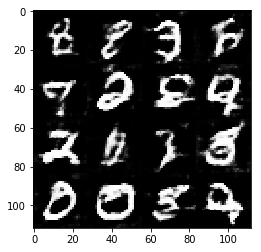

Epoch 1/2... Discriminator Loss: 1.1031... Generator Loss: 0.7447
Epoch 1/2... Discriminator Loss: 1.2604... Generator Loss: 0.5972
Epoch 1/2... Discriminator Loss: 1.2570... Generator Loss: 0.7368
Epoch 2/2... Discriminator Loss: 1.0521... Generator Loss: 0.8615
Epoch 2/2... Discriminator Loss: 0.9963... Generator Loss: 1.0953
Epoch 2/2... Discriminator Loss: 0.9720... Generator Loss: 1.4887
Epoch 2/2... Discriminator Loss: 1.2451... Generator Loss: 0.6532
Epoch 2/2... Discriminator Loss: 1.0937... Generator Loss: 0.8097
Epoch 2/2... Discriminator Loss: 0.9991... Generator Loss: 1.3242
Epoch 2/2... Discriminator Loss: 1.4216... Generator Loss: 0.5276


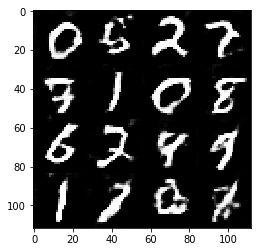

Epoch 2/2... Discriminator Loss: 1.2357... Generator Loss: 0.7309
Epoch 2/2... Discriminator Loss: 1.0213... Generator Loss: 1.0327
Epoch 2/2... Discriminator Loss: 0.8872... Generator Loss: 1.1287
Epoch 2/2... Discriminator Loss: 1.1627... Generator Loss: 1.8234
Epoch 2/2... Discriminator Loss: 0.9736... Generator Loss: 1.0468
Epoch 2/2... Discriminator Loss: 0.9944... Generator Loss: 1.0492
Epoch 2/2... Discriminator Loss: 0.8166... Generator Loss: 1.3622
Epoch 2/2... Discriminator Loss: 1.1120... Generator Loss: 0.7232
Epoch 2/2... Discriminator Loss: 1.5269... Generator Loss: 0.4747
Epoch 2/2... Discriminator Loss: 0.9350... Generator Loss: 1.1152


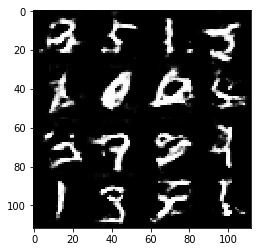

Epoch 2/2... Discriminator Loss: 1.0526... Generator Loss: 0.8133
Epoch 2/2... Discriminator Loss: 0.8015... Generator Loss: 1.3359
Epoch 2/2... Discriminator Loss: 1.6856... Generator Loss: 3.5059
Epoch 2/2... Discriminator Loss: 1.1848... Generator Loss: 1.5532
Epoch 2/2... Discriminator Loss: 1.3502... Generator Loss: 0.6923
Epoch 2/2... Discriminator Loss: 1.0186... Generator Loss: 1.0266
Epoch 2/2... Discriminator Loss: 1.0523... Generator Loss: 0.8230
Epoch 2/2... Discriminator Loss: 0.9244... Generator Loss: 1.1846
Epoch 2/2... Discriminator Loss: 1.0746... Generator Loss: 0.8847
Epoch 2/2... Discriminator Loss: 0.9000... Generator Loss: 1.4701


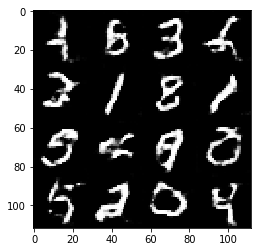

Epoch 2/2... Discriminator Loss: 1.0958... Generator Loss: 0.8908
Epoch 2/2... Discriminator Loss: 1.1354... Generator Loss: 0.7859
Epoch 2/2... Discriminator Loss: 0.9633... Generator Loss: 0.9854
Epoch 2/2... Discriminator Loss: 1.1917... Generator Loss: 0.6713
Epoch 2/2... Discriminator Loss: 0.8835... Generator Loss: 1.6499
Epoch 2/2... Discriminator Loss: 1.0093... Generator Loss: 0.9200
Epoch 2/2... Discriminator Loss: 1.4954... Generator Loss: 0.4948
Epoch 2/2... Discriminator Loss: 1.2193... Generator Loss: 0.7987
Epoch 2/2... Discriminator Loss: 0.9893... Generator Loss: 1.2457
Epoch 2/2... Discriminator Loss: 1.1193... Generator Loss: 2.1240


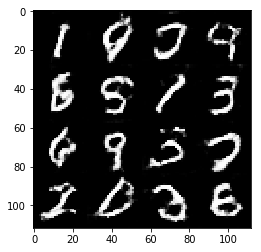

Epoch 2/2... Discriminator Loss: 0.9551... Generator Loss: 1.0548
Epoch 2/2... Discriminator Loss: 1.1584... Generator Loss: 1.0441
Epoch 2/2... Discriminator Loss: 0.8927... Generator Loss: 1.8905
Epoch 2/2... Discriminator Loss: 0.8313... Generator Loss: 1.5451
Epoch 2/2... Discriminator Loss: 1.1475... Generator Loss: 0.7261
Epoch 2/2... Discriminator Loss: 1.3407... Generator Loss: 0.5699
Epoch 2/2... Discriminator Loss: 0.8670... Generator Loss: 1.1057
Epoch 2/2... Discriminator Loss: 1.3899... Generator Loss: 3.0640
Epoch 2/2... Discriminator Loss: 0.8722... Generator Loss: 1.1141
Epoch 2/2... Discriminator Loss: 0.8743... Generator Loss: 1.5671


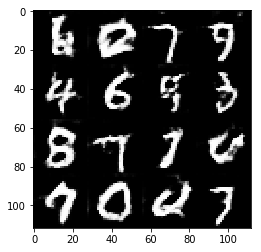

Epoch 2/2... Discriminator Loss: 1.0133... Generator Loss: 1.3172
Epoch 2/2... Discriminator Loss: 1.3389... Generator Loss: 2.0380
Epoch 2/2... Discriminator Loss: 1.2672... Generator Loss: 0.8236
Epoch 2/2... Discriminator Loss: 0.9357... Generator Loss: 1.0395
Epoch 2/2... Discriminator Loss: 0.9596... Generator Loss: 1.5056
Epoch 2/2... Discriminator Loss: 1.0232... Generator Loss: 1.0186
Epoch 2/2... Discriminator Loss: 1.1224... Generator Loss: 0.7055
Epoch 2/2... Discriminator Loss: 0.7973... Generator Loss: 1.4716
Epoch 2/2... Discriminator Loss: 1.3113... Generator Loss: 0.5822
Epoch 2/2... Discriminator Loss: 0.9654... Generator Loss: 1.0077


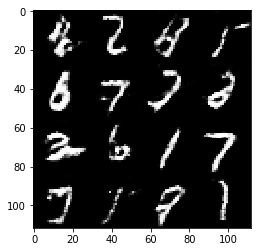

Epoch 2/2... Discriminator Loss: 0.9913... Generator Loss: 1.0613
Epoch 2/2... Discriminator Loss: 0.8077... Generator Loss: 1.1688
Epoch 2/2... Discriminator Loss: 0.7912... Generator Loss: 1.4772
Epoch 2/2... Discriminator Loss: 0.7245... Generator Loss: 1.4103
Epoch 2/2... Discriminator Loss: 0.9438... Generator Loss: 0.9874
Epoch 2/2... Discriminator Loss: 2.2238... Generator Loss: 0.2405
Epoch 2/2... Discriminator Loss: 1.0328... Generator Loss: 0.8980
Epoch 2/2... Discriminator Loss: 0.9364... Generator Loss: 1.4980
Epoch 2/2... Discriminator Loss: 1.1401... Generator Loss: 0.8482
Epoch 2/2... Discriminator Loss: 0.9955... Generator Loss: 2.1920


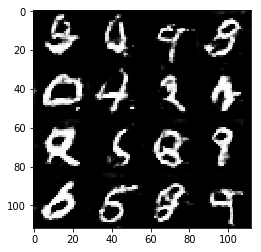

Epoch 2/2... Discriminator Loss: 1.0061... Generator Loss: 1.0796
Epoch 2/2... Discriminator Loss: 0.7311... Generator Loss: 1.7147
Epoch 2/2... Discriminator Loss: 0.9356... Generator Loss: 1.0895
Epoch 2/2... Discriminator Loss: 1.0397... Generator Loss: 0.8476
Epoch 2/2... Discriminator Loss: 1.5004... Generator Loss: 2.8247
Epoch 2/2... Discriminator Loss: 0.8398... Generator Loss: 1.4456
Epoch 2/2... Discriminator Loss: 0.9878... Generator Loss: 1.0538
Epoch 2/2... Discriminator Loss: 0.7649... Generator Loss: 1.8031
Epoch 2/2... Discriminator Loss: 1.1427... Generator Loss: 0.7443
Epoch 2/2... Discriminator Loss: 1.4033... Generator Loss: 0.4980


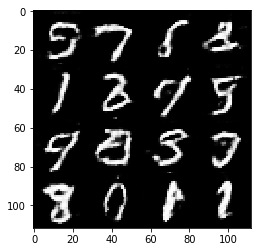

Epoch 2/2... Discriminator Loss: 0.8976... Generator Loss: 1.0847
Epoch 2/2... Discriminator Loss: 0.9974... Generator Loss: 0.8634
Epoch 2/2... Discriminator Loss: 1.3820... Generator Loss: 0.5499
Epoch 2/2... Discriminator Loss: 1.2126... Generator Loss: 2.3015
Epoch 2/2... Discriminator Loss: 0.9184... Generator Loss: 1.6008
Epoch 2/2... Discriminator Loss: 0.9427... Generator Loss: 1.2987
Epoch 2/2... Discriminator Loss: 1.2853... Generator Loss: 0.6719
Epoch 2/2... Discriminator Loss: 1.4293... Generator Loss: 0.5488
Epoch 2/2... Discriminator Loss: 0.7095... Generator Loss: 1.4083
Epoch 2/2... Discriminator Loss: 1.0878... Generator Loss: 1.6039


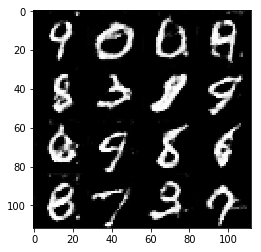

Epoch 2/2... Discriminator Loss: 1.0596... Generator Loss: 0.8706
Epoch 2/2... Discriminator Loss: 1.3166... Generator Loss: 0.5707
Epoch 2/2... Discriminator Loss: 0.9474... Generator Loss: 1.1645
Epoch 2/2... Discriminator Loss: 0.9328... Generator Loss: 1.0070
Epoch 2/2... Discriminator Loss: 1.0774... Generator Loss: 1.5291
Epoch 2/2... Discriminator Loss: 0.9973... Generator Loss: 1.3890
Epoch 2/2... Discriminator Loss: 1.0035... Generator Loss: 0.9262


In [32]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 5.4756... Generator Loss: 0.0147
Epoch 1/1... Discriminator Loss: 0.6143... Generator Loss: 4.8163
Epoch 1/1... Discriminator Loss: 0.6707... Generator Loss: 4.0125
Epoch 1/1... Discriminator Loss: 1.6221... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.8650
Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 1.5147
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 1.3732
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 1.6497
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.7499


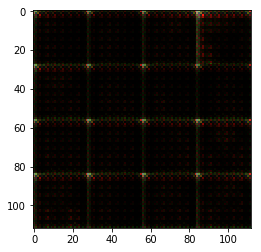

Epoch 1/1... Discriminator Loss: 1.5763... Generator Loss: 0.5827
Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 1.7298
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.5587
Epoch 1/1... Discriminator Loss: 1.6107... Generator Loss: 1.5320
Epoch 1/1... Discriminator Loss: 1.6822... Generator Loss: 0.4108
Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 1.0189
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.9284
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.8847


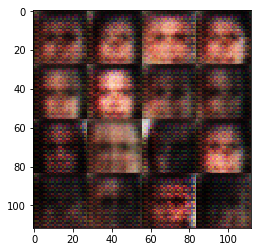

Epoch 1/1... Discriminator Loss: 1.9979... Generator Loss: 1.4729
Epoch 1/1... Discriminator Loss: 1.5650... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 1.5318... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.1405... Generator Loss: 1.1775
Epoch 1/1... Discriminator Loss: 1.1774... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.6063... Generator Loss: 0.4917
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.0934... Generator Loss: 1.0976
Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 1.0904


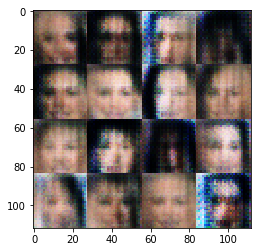

Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 1.4515
Epoch 1/1... Discriminator Loss: 1.5914... Generator Loss: 0.6227
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.8481
Epoch 1/1... Discriminator Loss: 1.2426... Generator Loss: 0.9883
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 1.1349
Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.9929
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.4782... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.5580


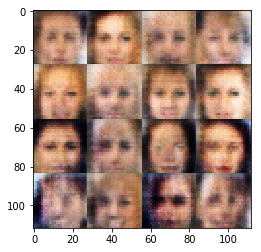

Epoch 1/1... Discriminator Loss: 1.5114... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 0.8494
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.9288
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.9288
Epoch 1/1... Discriminator Loss: 1.5271... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 1.5167... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.8592
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.8633
Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.8794


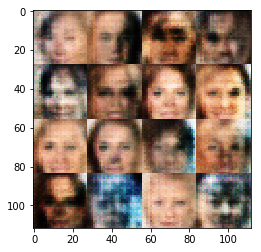

Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.9901
Epoch 1/1... Discriminator Loss: 1.4969... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 1.0473
Epoch 1/1... Discriminator Loss: 1.2432... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 0.8568
Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 1.0232
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.5649... Generator Loss: 0.4930


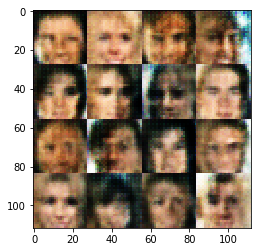

Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 1.0327
Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.6195
Epoch 1/1... Discriminator Loss: 1.5305... Generator Loss: 1.0101
Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 1.0743


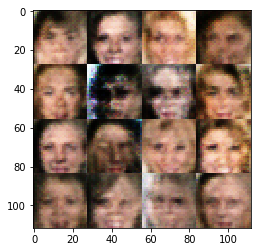

Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 1.0488
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.5874... Generator Loss: 1.4429
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.5305... Generator Loss: 0.5534
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 1.4025
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.5033... Generator Loss: 1.2836
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.8432


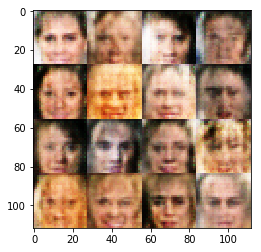

Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 1.5221... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 1.6371
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.0269... Generator Loss: 0.9323
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.9176
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.8980


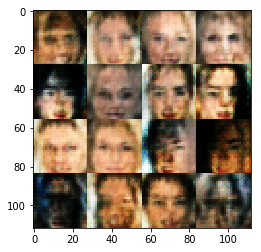

Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 0.8676
Epoch 1/1... Discriminator Loss: 1.5509... Generator Loss: 0.5557
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.8983
Epoch 1/1... Discriminator Loss: 1.7055... Generator Loss: 1.6838
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.8966
Epoch 1/1... Discriminator Loss: 1.7478... Generator Loss: 0.3192
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 1.1357
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 1.5267


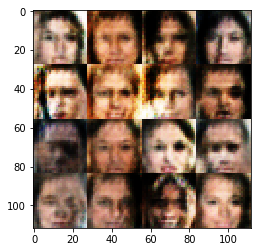

Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 1.5237
Epoch 1/1... Discriminator Loss: 1.1024... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.2455... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.5354... Generator Loss: 1.3599
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 2.2720
Epoch 1/1... Discriminator Loss: 1.6576... Generator Loss: 0.3669
Epoch 1/1... Discriminator Loss: 1.0094... Generator Loss: 1.1103
Epoch 1/1... Discriminator Loss: 1.0242... Generator Loss: 1.0580
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.6396
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.6031


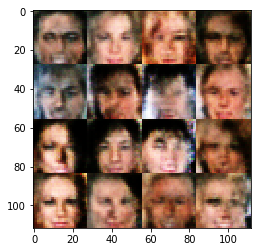

Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.5374
Epoch 1/1... Discriminator Loss: 1.1884... Generator Loss: 1.3432
Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 0.5963
Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 0.9950
Epoch 1/1... Discriminator Loss: 1.0452... Generator Loss: 1.3464
Epoch 1/1... Discriminator Loss: 1.7707... Generator Loss: 2.2664
Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 1.0280
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.5737
Epoch 1/1... Discriminator Loss: 0.7388... Generator Loss: 1.6530
Epoch 1/1... Discriminator Loss: 0.9153... Generator Loss: 1.0950


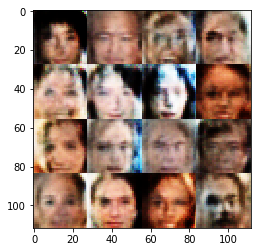

Epoch 1/1... Discriminator Loss: 1.0627... Generator Loss: 1.4927
Epoch 1/1... Discriminator Loss: 1.0478... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 0.7611... Generator Loss: 1.2842
Epoch 1/1... Discriminator Loss: 1.1109... Generator Loss: 1.2103
Epoch 1/1... Discriminator Loss: 1.0878... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 0.7822... Generator Loss: 1.5536
Epoch 1/1... Discriminator Loss: 0.8845... Generator Loss: 3.4027
Epoch 1/1... Discriminator Loss: 0.7562... Generator Loss: 1.6775
Epoch 1/1... Discriminator Loss: 0.7903... Generator Loss: 1.3159
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.6678


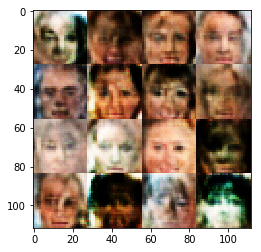

Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 2.3386
Epoch 1/1... Discriminator Loss: 0.6498... Generator Loss: 2.3003
Epoch 1/1... Discriminator Loss: 0.8129... Generator Loss: 1.2028
Epoch 1/1... Discriminator Loss: 1.0058... Generator Loss: 1.0494
Epoch 1/1... Discriminator Loss: 1.0440... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.8232... Generator Loss: 0.3173
Epoch 1/1... Discriminator Loss: 0.8018... Generator Loss: 1.3448
Epoch 1/1... Discriminator Loss: 0.9961... Generator Loss: 1.0982
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.0178... Generator Loss: 1.1588


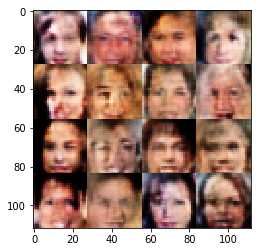

Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 0.9113
Epoch 1/1... Discriminator Loss: 0.9956... Generator Loss: 4.4732
Epoch 1/1... Discriminator Loss: 0.7742... Generator Loss: 1.2968
Epoch 1/1... Discriminator Loss: 1.5966... Generator Loss: 0.3802
Epoch 1/1... Discriminator Loss: 1.5577... Generator Loss: 0.4163
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 0.9596... Generator Loss: 1.1959
Epoch 1/1... Discriminator Loss: 1.4982... Generator Loss: 0.4328
Epoch 1/1... Discriminator Loss: 1.0709... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.5334


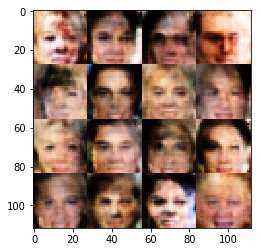

Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.4902
Epoch 1/1... Discriminator Loss: 0.9386... Generator Loss: 1.1703
Epoch 1/1... Discriminator Loss: 0.7836... Generator Loss: 1.5513
Epoch 1/1... Discriminator Loss: 0.7840... Generator Loss: 1.2243
Epoch 1/1... Discriminator Loss: 0.9066... Generator Loss: 1.0750
Epoch 1/1... Discriminator Loss: 1.8589... Generator Loss: 3.9423
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 1.5486
Epoch 1/1... Discriminator Loss: 0.9398... Generator Loss: 0.9760
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.5160
Epoch 1/1... Discriminator Loss: 0.8826... Generator Loss: 2.1191


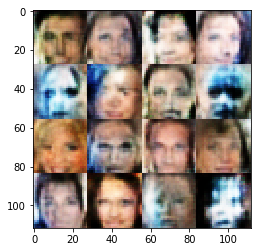

Epoch 1/1... Discriminator Loss: 1.5248... Generator Loss: 0.4698
Epoch 1/1... Discriminator Loss: 1.0437... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 0.6712... Generator Loss: 1.7858
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 0.7949... Generator Loss: 1.2541
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 2.7653
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 0.9705
Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 1.5749
Epoch 1/1... Discriminator Loss: 1.1248... Generator Loss: 1.8899
Epoch 1/1... Discriminator Loss: 1.6443... Generator Loss: 0.3717


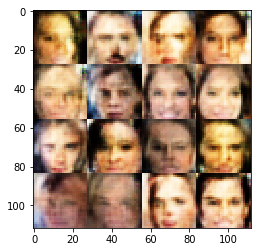

Epoch 1/1... Discriminator Loss: 0.7998... Generator Loss: 1.5572
Epoch 1/1... Discriminator Loss: 1.5037... Generator Loss: 2.0960
Epoch 1/1... Discriminator Loss: 0.9701... Generator Loss: 2.1798
Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 0.5714
Epoch 1/1... Discriminator Loss: 0.9652... Generator Loss: 2.8449
Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 2.4648
Epoch 1/1... Discriminator Loss: 0.7147... Generator Loss: 1.2672
Epoch 1/1... Discriminator Loss: 0.6145... Generator Loss: 1.6351
Epoch 1/1... Discriminator Loss: 0.9177... Generator Loss: 1.2283
Epoch 1/1... Discriminator Loss: 0.8504... Generator Loss: 1.1806


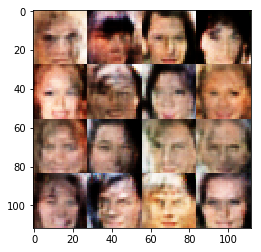

Epoch 1/1... Discriminator Loss: 0.9528... Generator Loss: 1.3719
Epoch 1/1... Discriminator Loss: 0.6378... Generator Loss: 1.8568
Epoch 1/1... Discriminator Loss: 0.6589... Generator Loss: 3.1591
Epoch 1/1... Discriminator Loss: 0.7888... Generator Loss: 1.3316
Epoch 1/1... Discriminator Loss: 1.0300... Generator Loss: 3.0663
Epoch 1/1... Discriminator Loss: 0.7939... Generator Loss: 1.3050
Epoch 1/1... Discriminator Loss: 0.9559... Generator Loss: 2.1710
Epoch 1/1... Discriminator Loss: 1.5620... Generator Loss: 0.3989
Epoch 1/1... Discriminator Loss: 0.6465... Generator Loss: 1.8005
Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 1.5849


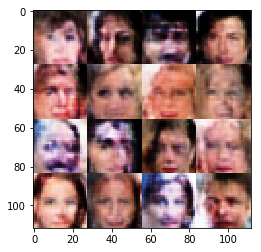

Epoch 1/1... Discriminator Loss: 0.8615... Generator Loss: 1.0735
Epoch 1/1... Discriminator Loss: 0.8040... Generator Loss: 1.7211
Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 0.6164
Epoch 1/1... Discriminator Loss: 0.7745... Generator Loss: 1.2487
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 0.9214... Generator Loss: 1.4839
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.5390
Epoch 1/1... Discriminator Loss: 0.8976... Generator Loss: 2.2512
Epoch 1/1... Discriminator Loss: 0.6792... Generator Loss: 1.6416
Epoch 1/1... Discriminator Loss: 0.5363... Generator Loss: 2.8896


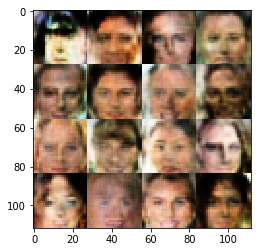

Epoch 1/1... Discriminator Loss: 0.9117... Generator Loss: 1.0643
Epoch 1/1... Discriminator Loss: 0.6405... Generator Loss: 1.9326
Epoch 1/1... Discriminator Loss: 0.7544... Generator Loss: 1.5536
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.5196
Epoch 1/1... Discriminator Loss: 0.8598... Generator Loss: 1.2544
Epoch 1/1... Discriminator Loss: 0.9646... Generator Loss: 1.5020
Epoch 1/1... Discriminator Loss: 0.6897... Generator Loss: 1.6410
Epoch 1/1... Discriminator Loss: 0.7415... Generator Loss: 1.2879
Epoch 1/1... Discriminator Loss: 1.0934... Generator Loss: 2.0513
Epoch 1/1... Discriminator Loss: 0.4914... Generator Loss: 3.4816


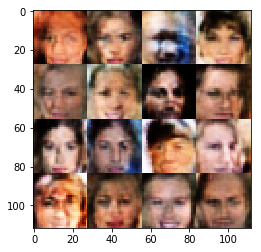

Epoch 1/1... Discriminator Loss: 1.5610... Generator Loss: 2.0461
Epoch 1/1... Discriminator Loss: 0.9604... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 0.7379... Generator Loss: 1.3460
Epoch 1/1... Discriminator Loss: 1.7142... Generator Loss: 2.7112
Epoch 1/1... Discriminator Loss: 2.1133... Generator Loss: 4.1861
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.5489
Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 2.2872
Epoch 1/1... Discriminator Loss: 0.6081... Generator Loss: 1.6754
Epoch 1/1... Discriminator Loss: 0.5180... Generator Loss: 2.6849
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 0.6860


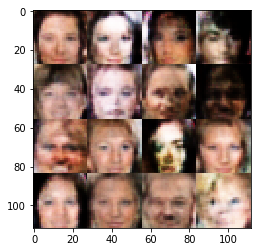

Epoch 1/1... Discriminator Loss: 0.7852... Generator Loss: 1.2799
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 1.5089
Epoch 1/1... Discriminator Loss: 0.8689... Generator Loss: 1.3218
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 0.9390... Generator Loss: 0.9359
Epoch 1/1... Discriminator Loss: 0.6553... Generator Loss: 2.1591
Epoch 1/1... Discriminator Loss: 1.0084... Generator Loss: 2.5487
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 0.7399... Generator Loss: 2.0698
Epoch 1/1... Discriminator Loss: 0.6299... Generator Loss: 2.5621


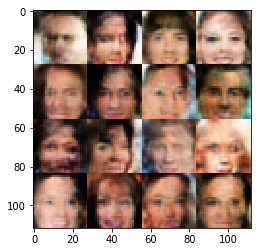

Epoch 1/1... Discriminator Loss: 0.7343... Generator Loss: 1.5725
Epoch 1/1... Discriminator Loss: 0.7880... Generator Loss: 1.2123
Epoch 1/1... Discriminator Loss: 0.7522... Generator Loss: 2.4204
Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 0.8893
Epoch 1/1... Discriminator Loss: 0.9356... Generator Loss: 1.8600
Epoch 1/1... Discriminator Loss: 0.5307... Generator Loss: 2.3355
Epoch 1/1... Discriminator Loss: 0.4793... Generator Loss: 2.4974
Epoch 1/1... Discriminator Loss: 0.7687... Generator Loss: 1.2327
Epoch 1/1... Discriminator Loss: 0.6902... Generator Loss: 1.3674
Epoch 1/1... Discriminator Loss: 1.1464... Generator Loss: 0.6827


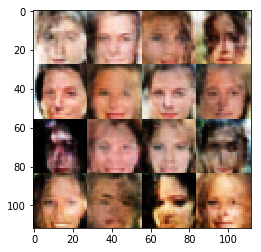

Epoch 1/1... Discriminator Loss: 0.8478... Generator Loss: 1.5547
Epoch 1/1... Discriminator Loss: 0.7454... Generator Loss: 1.4144
Epoch 1/1... Discriminator Loss: 0.5742... Generator Loss: 1.9248
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 3.6091
Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 0.9079
Epoch 1/1... Discriminator Loss: 0.7753... Generator Loss: 1.4646
Epoch 1/1... Discriminator Loss: 0.7106... Generator Loss: 1.4476
Epoch 1/1... Discriminator Loss: 0.8765... Generator Loss: 1.4530
Epoch 1/1... Discriminator Loss: 0.5371... Generator Loss: 2.2336


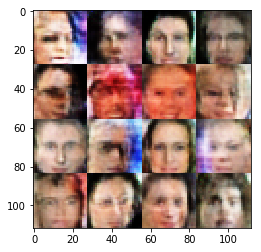

Epoch 1/1... Discriminator Loss: 0.6769... Generator Loss: 1.5002
Epoch 1/1... Discriminator Loss: 1.1271... Generator Loss: 1.4730
Epoch 1/1... Discriminator Loss: 0.5269... Generator Loss: 2.0266
Epoch 1/1... Discriminator Loss: 0.5529... Generator Loss: 1.8844
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.4938
Epoch 1/1... Discriminator Loss: 0.9763... Generator Loss: 2.3920
Epoch 1/1... Discriminator Loss: 0.7311... Generator Loss: 1.4186
Epoch 1/1... Discriminator Loss: 0.9992... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 0.7895... Generator Loss: 1.2375
Epoch 1/1... Discriminator Loss: 1.0683... Generator Loss: 0.8008


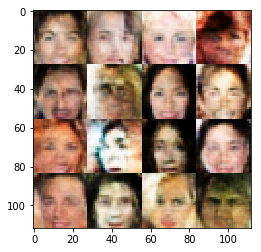

Epoch 1/1... Discriminator Loss: 0.7385... Generator Loss: 1.9461
Epoch 1/1... Discriminator Loss: 0.9496... Generator Loss: 2.2467
Epoch 1/1... Discriminator Loss: 0.4960... Generator Loss: 2.7404
Epoch 1/1... Discriminator Loss: 0.6169... Generator Loss: 1.6450
Epoch 1/1... Discriminator Loss: 0.4873... Generator Loss: 2.3687
Epoch 1/1... Discriminator Loss: 0.9626... Generator Loss: 1.9985
Epoch 1/1... Discriminator Loss: 0.8861... Generator Loss: 1.0323
Epoch 1/1... Discriminator Loss: 0.6266... Generator Loss: 1.6924
Epoch 1/1... Discriminator Loss: 0.7508... Generator Loss: 1.2238
Epoch 1/1... Discriminator Loss: 0.7228... Generator Loss: 1.2847


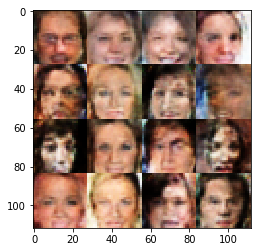

Epoch 1/1... Discriminator Loss: 0.6484... Generator Loss: 1.5682
Epoch 1/1... Discriminator Loss: 0.6698... Generator Loss: 1.4755
Epoch 1/1... Discriminator Loss: 1.7226... Generator Loss: 0.3806
Epoch 1/1... Discriminator Loss: 0.6577... Generator Loss: 1.6384
Epoch 1/1... Discriminator Loss: 0.8210... Generator Loss: 1.3603
Epoch 1/1... Discriminator Loss: 0.7459... Generator Loss: 1.2755
Epoch 1/1... Discriminator Loss: 0.6193... Generator Loss: 2.0408
Epoch 1/1... Discriminator Loss: 0.9679... Generator Loss: 0.8669
Epoch 1/1... Discriminator Loss: 0.7166... Generator Loss: 1.4535
Epoch 1/1... Discriminator Loss: 0.5987... Generator Loss: 3.2525


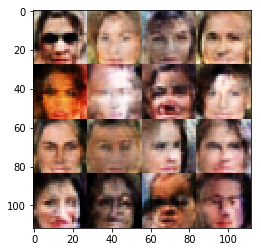

Epoch 1/1... Discriminator Loss: 0.9527... Generator Loss: 0.9694
Epoch 1/1... Discriminator Loss: 0.5903... Generator Loss: 2.0529
Epoch 1/1... Discriminator Loss: 0.9299... Generator Loss: 0.9621
Epoch 1/1... Discriminator Loss: 0.6484... Generator Loss: 1.5298
Epoch 1/1... Discriminator Loss: 0.4284... Generator Loss: 3.3433
Epoch 1/1... Discriminator Loss: 0.5274... Generator Loss: 2.1605
Epoch 1/1... Discriminator Loss: 0.5963... Generator Loss: 1.6172
Epoch 1/1... Discriminator Loss: 0.6005... Generator Loss: 1.8116
Epoch 1/1... Discriminator Loss: 0.5893... Generator Loss: 1.8272
Epoch 1/1... Discriminator Loss: 1.5023... Generator Loss: 2.0153


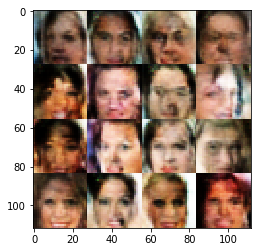

Epoch 1/1... Discriminator Loss: 0.7949... Generator Loss: 1.7786
Epoch 1/1... Discriminator Loss: 0.8512... Generator Loss: 2.5663
Epoch 1/1... Discriminator Loss: 0.5251... Generator Loss: 2.2226
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 0.6166
Epoch 1/1... Discriminator Loss: 0.7011... Generator Loss: 3.9926
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 3.8695
Epoch 1/1... Discriminator Loss: 0.5007... Generator Loss: 3.5518
Epoch 1/1... Discriminator Loss: 0.3919... Generator Loss: 3.2918
Epoch 1/1... Discriminator Loss: 1.6769... Generator Loss: 0.4030
Epoch 1/1... Discriminator Loss: 0.9189... Generator Loss: 0.9425


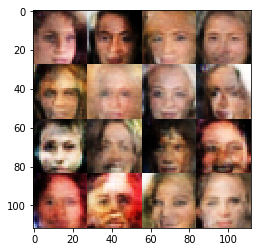

Epoch 1/1... Discriminator Loss: 0.6872... Generator Loss: 1.7198
Epoch 1/1... Discriminator Loss: 0.5354... Generator Loss: 2.2333
Epoch 1/1... Discriminator Loss: 0.4816... Generator Loss: 2.4387
Epoch 1/1... Discriminator Loss: 0.6715... Generator Loss: 1.7976
Epoch 1/1... Discriminator Loss: 2.7588... Generator Loss: 3.9451
Epoch 1/1... Discriminator Loss: 0.7525... Generator Loss: 2.5084
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 3.2628
Epoch 1/1... Discriminator Loss: 0.6068... Generator Loss: 2.3817
Epoch 1/1... Discriminator Loss: 0.6692... Generator Loss: 4.0666
Epoch 1/1... Discriminator Loss: 0.4996... Generator Loss: 2.2573


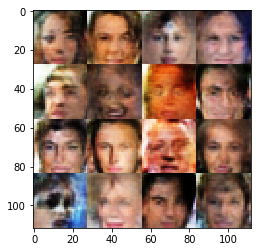

Epoch 1/1... Discriminator Loss: 0.7140... Generator Loss: 1.4609
Epoch 1/1... Discriminator Loss: 0.5190... Generator Loss: 2.1967
Epoch 1/1... Discriminator Loss: 0.3909... Generator Loss: 3.6248
Epoch 1/1... Discriminator Loss: 0.4428... Generator Loss: 2.7408
Epoch 1/1... Discriminator Loss: 0.7275... Generator Loss: 1.4426
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.5885


In [33]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.